<center><img src="https://raw.githubusercontent.com/zarr-developers/community/master/logos/logo2.png"></center>

# <center>A tech talk by Zain Patel 👨‍💻</center>


```console
$ pip install zarr dask
```

# Motivation: Why Zarr?

## Problem statement:

There is some computation we want to perform.

The inputs and outputs are multidimensional arrays 🔢 (a.k.a **tensors**)

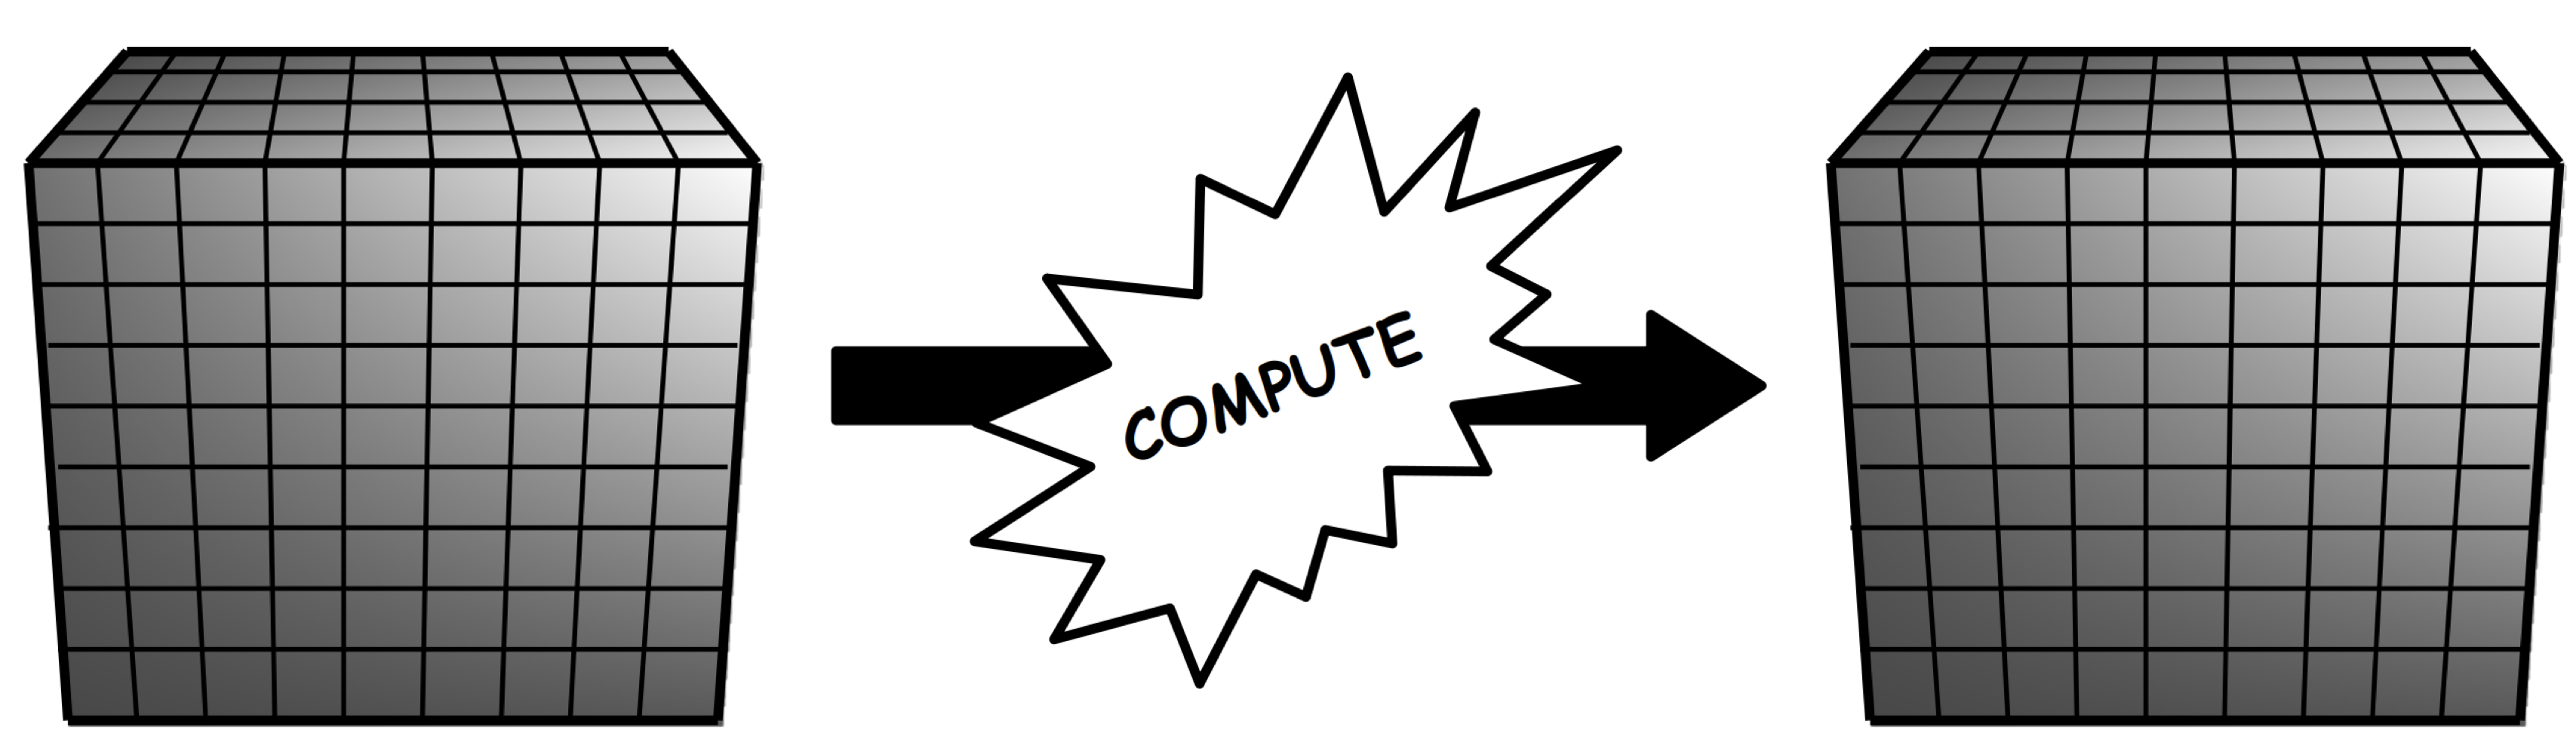

# 5 🗝 features 

# 1. Larger than Memory

Input and/or output tensors are too big to fit comfortably into main memory

# 2. Computation can be parallelised

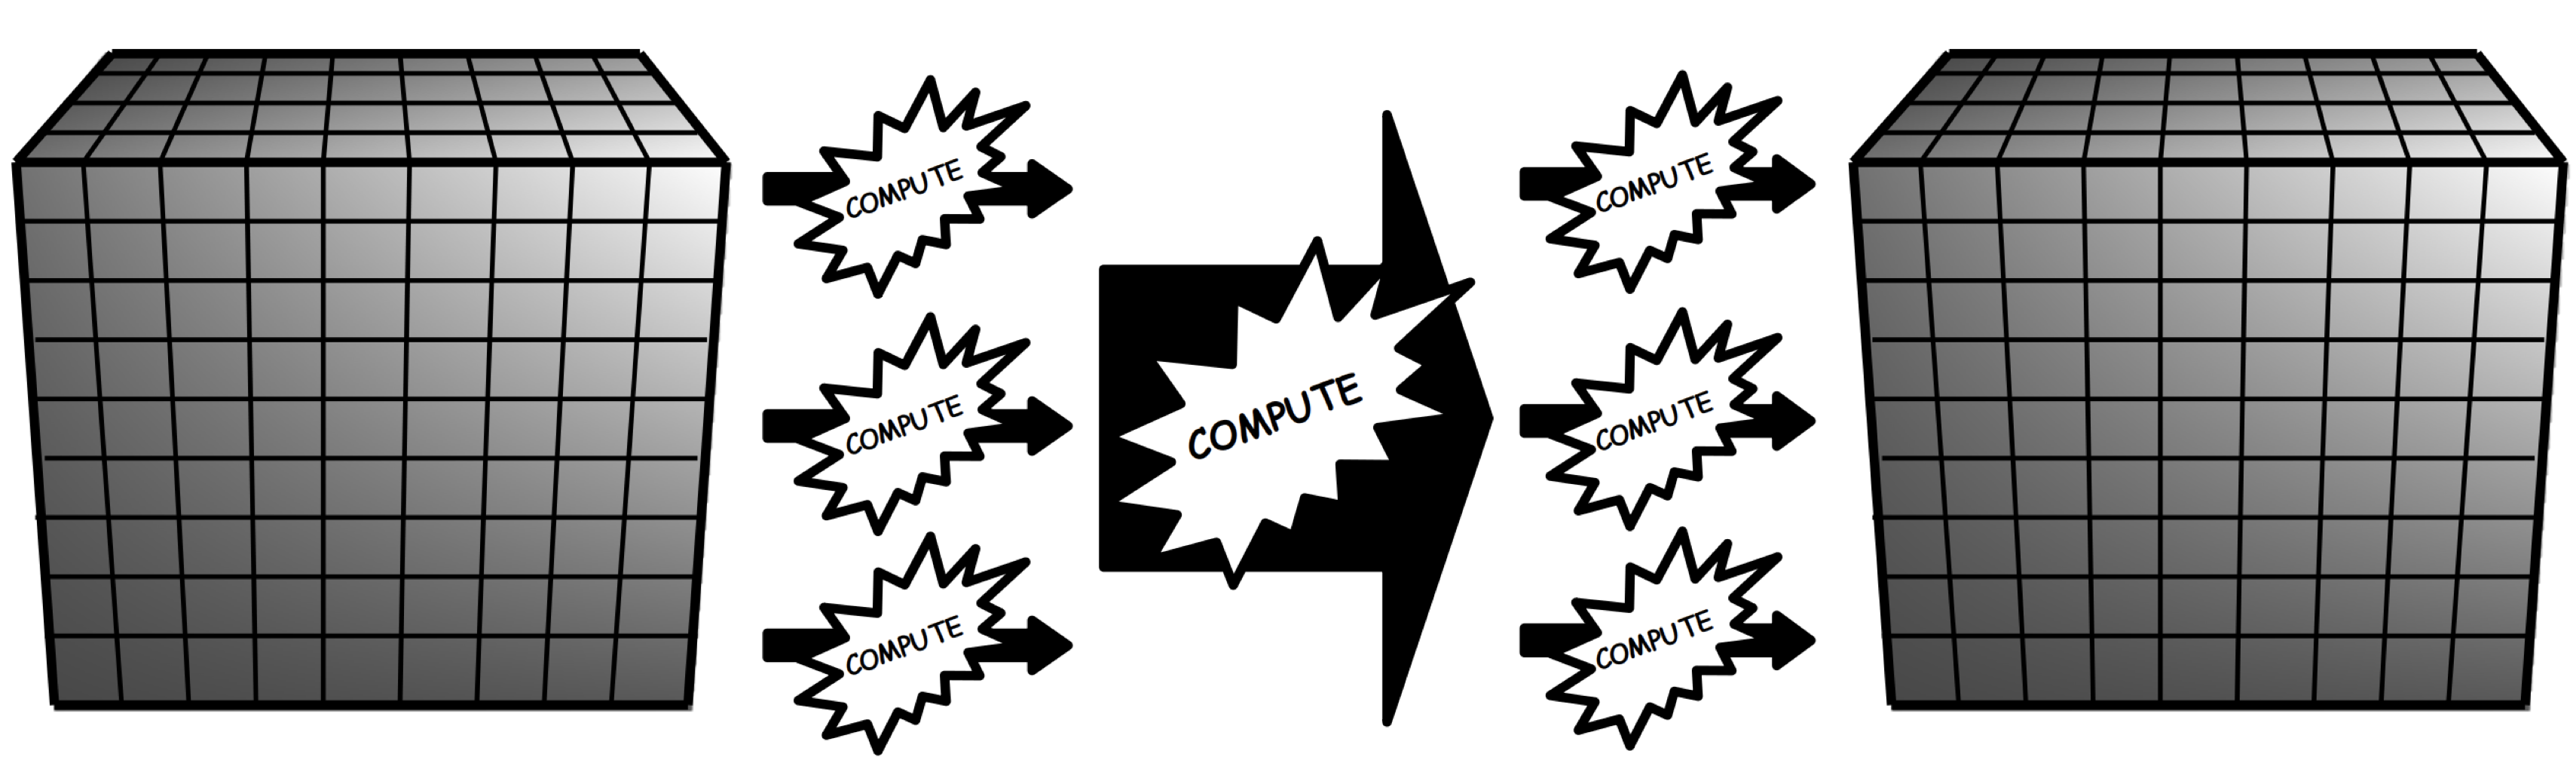

At least some parts of the computation can be parallelised by processing the data in _chunks_

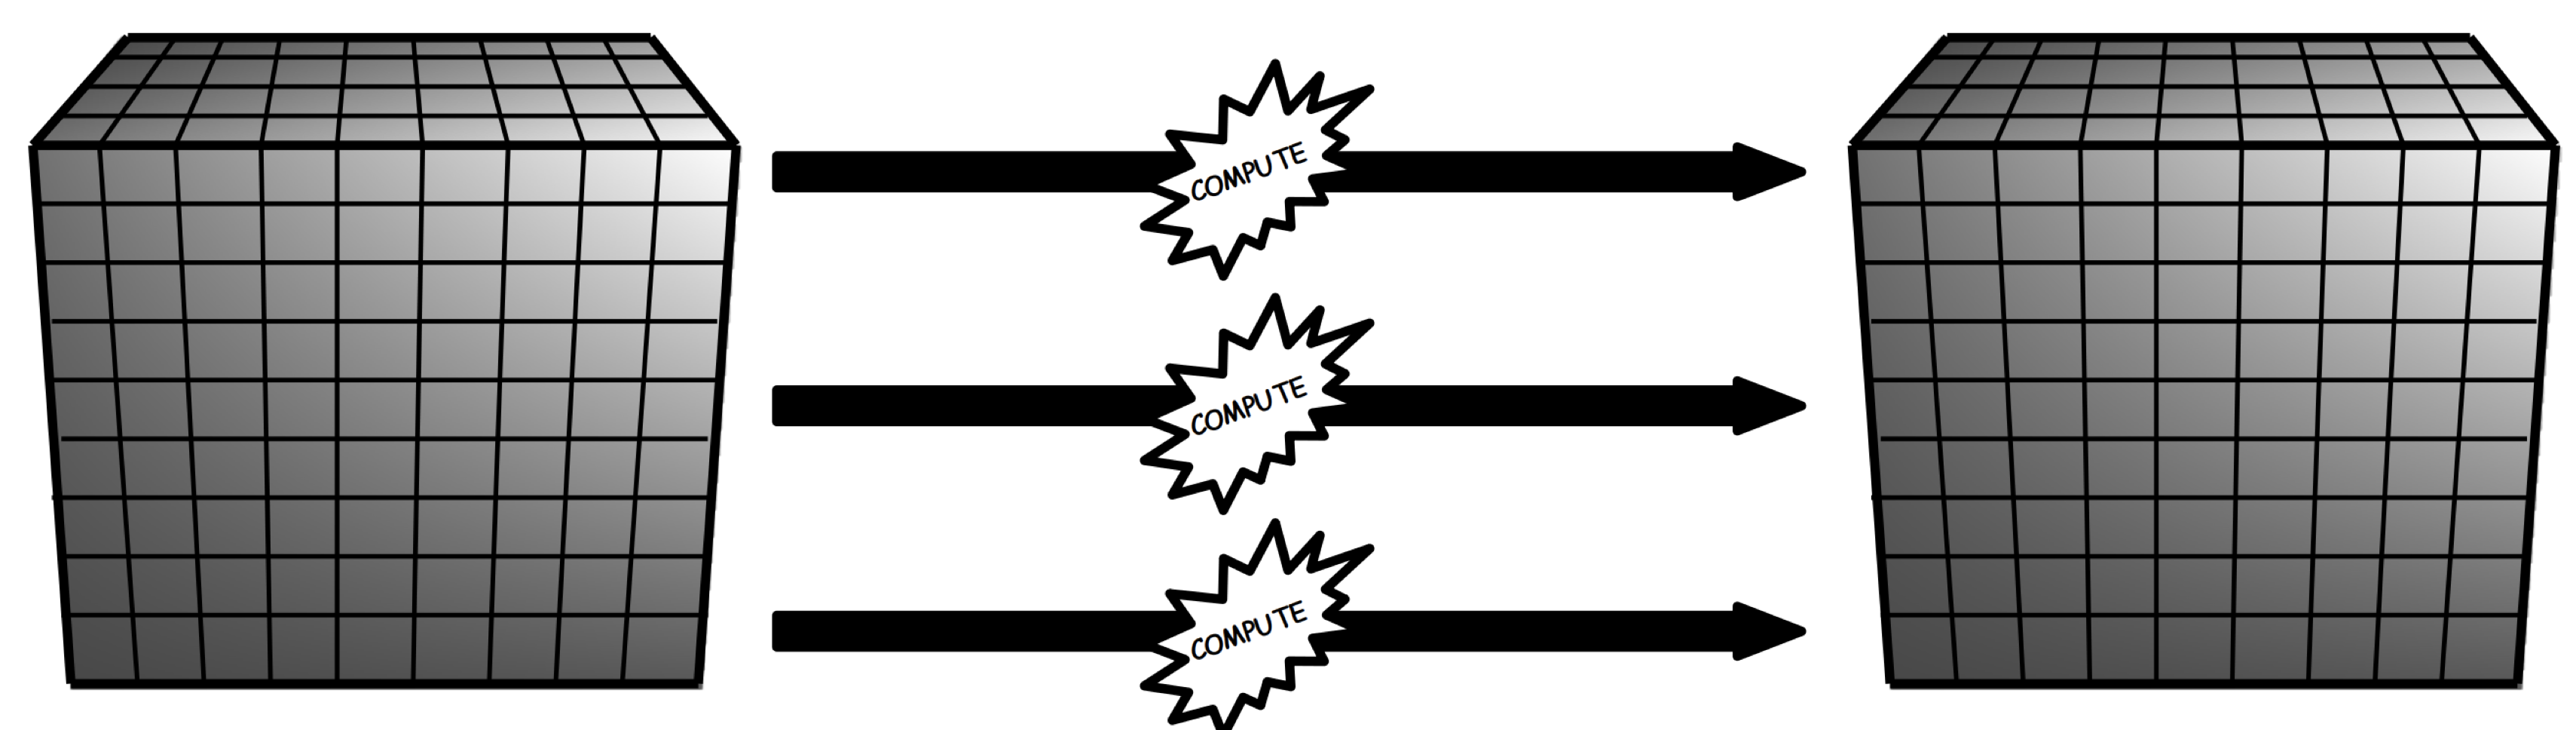

Sometimes, embarassingly parallel <span style="font-size:50pt">😳</span>

# 3. I/O is the bottleneck 💿

Sometimes, if your computation complexity is moderate, a significant amount of your time may be spent in reading and/or writing data.

N/B: this bottleneck may be due to limited I/O bandwith or a certain part of your I/O stack not being parallel.

# 4. Data is compressible 🗜

* Compression is a very active area of innovation
* Modern compressors achieve very good compresision ratios with high speed/throughput
* Compression can increase _effective_ I/O bandwith, somestimes dramatically

### Obligatory Silicon Valley reference:



<center><img src="https://ep60qmdjq8-flywheel.netdna-ssl.com/wp-content/uploads/2016/07/guilfoyle.jpg"></center>

# 5. Speed matters 🏃‍♂️

Main usecase here is with scientific data anylsis, where shortening the loop between exploratory science -> interactive analysis -> many rounds of summarising, visualising, hypothesising, modelling, testing and repeating the loop is crucial

# Problem: Key features 🔑

0. Inputs and outputs are tensors
1. Data is larger than memory
2. Computation can be parallelised
3. I/O is the bottleneck
4. Data is compressible
5. Speed matters

# Solution:

1. Chunked, parallel tensor computing framework
2. Chunked, parallel tensor storage library

Align the chunks!

# Cameo apperance:

<center><img src="https://docs.dask.org/en/latest/_images/dask_horizontal.svg"></center>

Our favourite chunked parallel tensor computing framework

# Parallel tensor computing framework ✅

```python
import dask.array as da

a = ... # what goes here?
x = da.from_array(a)

y = (x - x.mean(axis=1)) / x.std(axis=1)
u, s, v = da.linalg.svd_compressed(y, 20)

u = u.compute()
```

1. Write code using a numpy-like API
2. Parallel execution on local workstations, HPC cluster, Kubernetes cluster, QB's 10,000 Sagemaker instances (totally on purpose), etc... 

# Parallel tensor storage library ❌

1. h5py: can store tensors, chunk them, compress chunks, smooth numpy integration and supports hierachies BUT no thread based parallelism, no parallel compressed writes, not easy to plug in new compressors, no support for cloud object stores

2. bcolz: simple implementation (in a good way), simple storage format, chunked storage but primarily for string data BUT chunking in one dimension only, no support for cloud object stores

# How hard could it be...

### ... to implement a chunked storage library for tensor data that supported parallel reads, parallel writes, was easy to plug in new compressors, and easy to plug in different storage systems like cloud object stores?

# &lt;montage/&gt;

3 years, 1,191 commits, 302 issues, 208 PRs, 40 releases, 9 repos, and at least 2 babies later...

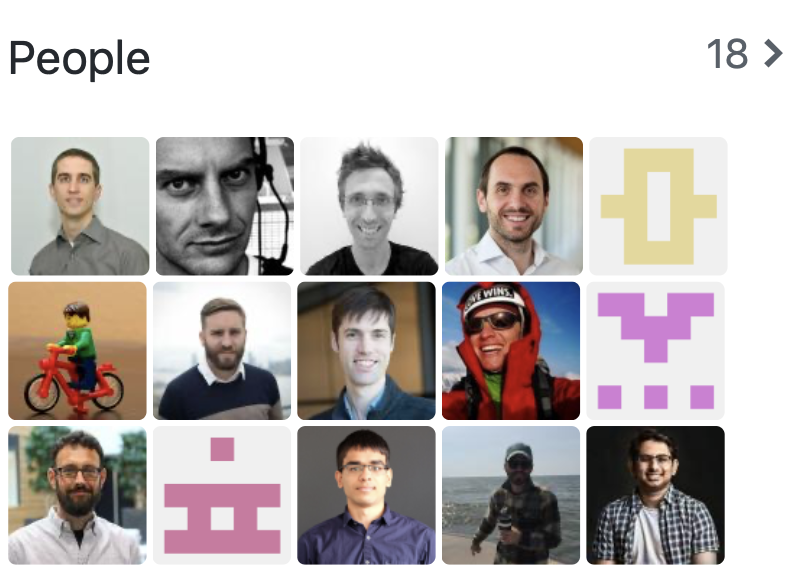

```console
$ pip install zarr
```

```console
$ conda install -c conda-forge zarr
```

In [ ]:
import zarr
zarr.__version__

# Conceptual model

1. Multiple arrays can be created and organised into a hierachy of groups
2. Each array is divided into regular shaped chunks (chunk sized can be manually specified or a best guess to an optimal chunk size can be made automatically)
3. Each chunk is compressed before storage

# Creating a hierachy 🌴

In [ ]:
# create directory store (saved on local filesystem, basically) and root of store
... # create directory store with name `example.zarr` 
... # create group using the initialised store

```python
store = zarr.DirectoryStore('example.zarr')
root = zarr.group(store)
root
```

# Creating an array 🔢

In [ ]:
# create a 2-dimensional 10kx10k array of 32-bit integers (a leaf node in our hierachy) with 1kx1k chunks
...
...

```python
hello = root.zeros('hello',
                   shape=(10000, 10000),
                   chunks=(1000, 1000),
                   dtype='<i4')
```

Alternatively, supports h5py style interface with `root.create_dataset`.

# Creating a (big) array 👀

In [ ]:
# Create a 2d 100mx100m array, chunked into 10kx10k of 32 bit integers
...
...

```python
big = root.zeros('big',
                 shape=(100_000_000, 100_000_000),
                 chunks=(10_000, 10_000),
                 dtype='i4')
```

In [ ]:
# Print info about the big dataset/array
big.info

* That's a 35 petabyte array
* NB: Chunks are initialized on write (thankfully...)

# Writing data into an array ✏️

* Same API as numpy or h5py

In [ ]:
# [0, 0:20000]
# [0:20000, 0]

```python
big[0, 0:20000] = np.arrange(20000)
big[0:20000, 0] = np.arrange(20000)
```

# Reading data from an array 📖

* Same API as slicing into a numpy array or reading from an h5py dataset

In [ ]:
big[0:1000, 0:1000] # read first 1kx1k chunk of the array

In [ ]:
# Chunks are initialised on write
big.info

In [ ]:
# Fill value (for this dtype: 0) is used when reading unwritten regions:
big[-1000:, -1000:]

In [ ]:
# Reading the whole array (💔 my RAM)
big[:]

# Files on disk

In [ ]:
!ls -a example.zarr

# Array metadata

In [ ]:
!cat example.zarr/big/.zarray

# Pluggable storage 🔌

Using the directory store means that Zarr will use a directory on your local filesystem, but there are other stores available, including a zipped store (zipfile), SQL store, Azure Blob store, S3FS, GCFS store, MongoDB store, Redis store, and the list goes on.

It's also very easy to build a store, they only need to implement a `MutableMapping` interface (basically a dictionary). Think Kedro datasets!

More technically, it needs to be `dict`-like, which means specifying `__get_item__`, `__set_item__` and `__iter__`.